<a href="https://colab.research.google.com/github/lucianoh34/RedesNeurais/blob/main/Forecasting_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
pip install yfinance tensorflow scikit-learn

[*********************100%%**********************]  1 of 1 completed


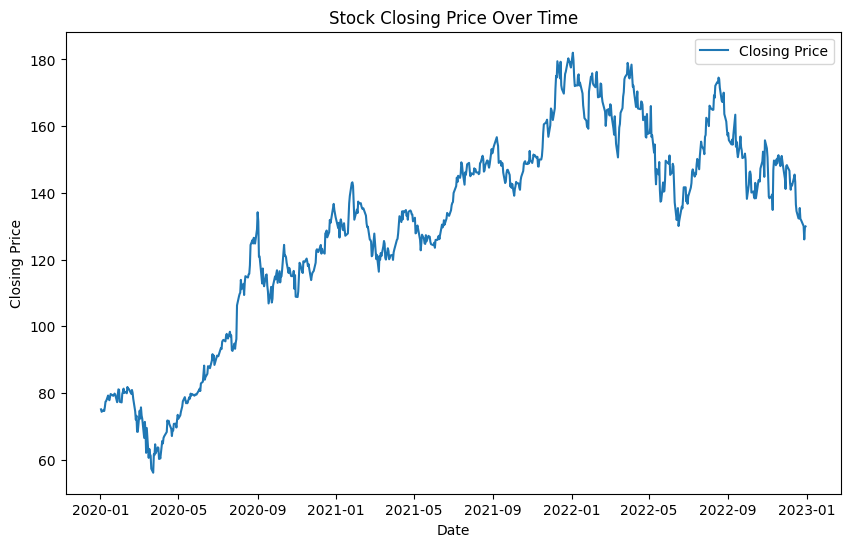

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers

# Coletando dados de ações da Yahoo Finance usando yfinance
start_date = '2020-01-01'
end_date = '2023-01-01'
ticker = 'AAPL'  # Apple Inc.

df = yf.download(ticker, start=start_date, end=end_date)

# Visualização dos dados de fechamento ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Closing Price')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



In [34]:
# Preparação dos dados para modelagem de séries temporais
sequence_length = 30  # comprimento da sequência para previsão
close_prices = df['Close'].values
X, y = [], []
for i in range(len(close_prices) - sequence_length):
    X.append(close_prices[i:i+sequence_length])
    y.append(close_prices[i+sequence_length])
X = np.array(X)
y = np.array(y)

# Dividindo os dados em conjunto de treino e teste
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Modelo de Convolução 1D
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Conv1D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1)(x)
model_conv1d = keras.Model(inputs, outputs)

model_conv1d.compile(optimizer='adam', loss='mse')

# Treinamento do modelo de Convolução 1D
history_conv1d = model_conv1d.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo de Convolução 1D usando MAPE
y_pred_conv1d = model_conv1d.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_conv1d = mean_absolute_percentage_error(y_test, y_pred_conv1d)
print(f"MAPE 1D Convolutional: {mape_conv1d:.2f}")

Epoch 1/50
17/17 [==============================] - 1s 13ms/step - loss: 16428.7285 - val_loss: 25084.2422
Epoch 2/50
17/17 [==============================] - 0s 4ms/step - loss: 16073.3906 - val_loss: 24117.7031
Epoch 3/50
17/17 [==============================] - 0s 4ms/step - loss: 15368.5596 - val_loss: 22202.8320
Epoch 4/50
17/17 [==============================] - 0s 5ms/step - loss: 14113.3301 - val_loss: 19009.5293
Epoch 5/50
17/17 [==============================] - 0s 4ms/step - loss: 12201.1123 - val_loss: 14591.1572
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 9835.0615 - val_loss: 9207.7227
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 7324.5947 - val_loss: 4189.6445
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 5172.4956 - val_loss: 910.4999
Epoch 9/50
17/17 [==============================] - 0s 5ms/step - loss: 3591.4595 - val_loss: 207.2322
Epoch 10/50
17/17 [==============================] - 0s

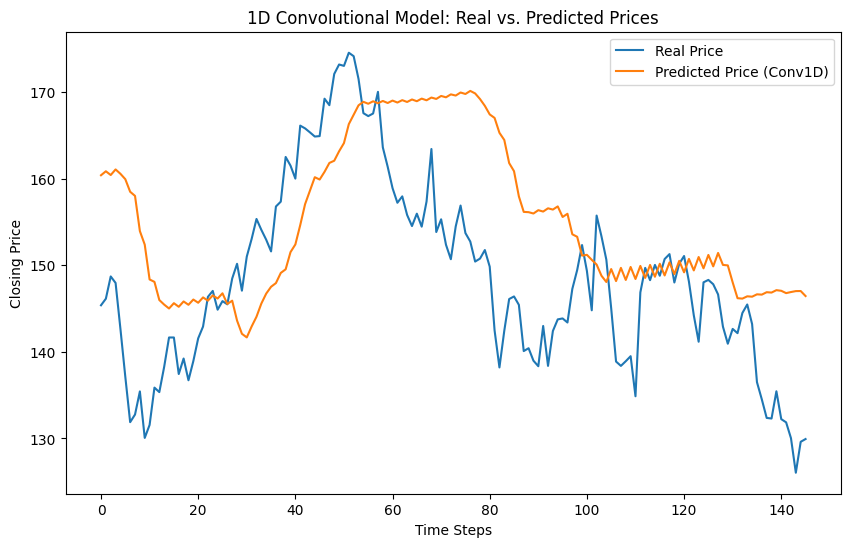

In [36]:
# Gráfico das previsões do modelo de Convolução 1D vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_conv1d)), y_pred_conv1d, label='Predicted Price (Conv1D)')
plt.title('1D Convolutional Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [37]:
# Modelo Densely Connected
inputs = keras.Input(shape=(sequence_length,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_dense = keras.Model(inputs, outputs)

model_dense.compile(optimizer='adam', loss='mse')

# Treinamento do modelo Densely Connected
history_dense = model_dense.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo Densely Connected usando MAPE
y_pred_dense = model_dense.predict(X_test_scaled)
mape_dense = mean_absolute_percentage_error(y_test, y_pred_dense)
print(f"MAPE Densely Connected: {mape_dense:.2f}")

Epoch 1/50
17/17 [==============================] - 1s 12ms/step - loss: 16524.1621 - val_loss: 25217.3750
Epoch 2/50
17/17 [==============================] - 0s 3ms/step - loss: 16146.0400 - val_loss: 24398.9492
Epoch 3/50
17/17 [==============================] - 0s 3ms/step - loss: 15580.4707 - val_loss: 22833.1934
Epoch 4/50
17/17 [==============================] - 0s 3ms/step - loss: 14565.4189 - val_loss: 20121.7656
Epoch 5/50
17/17 [==============================] - 0s 3ms/step - loss: 13011.2393 - val_loss: 15829.5098
Epoch 6/50
17/17 [==============================] - 0s 3ms/step - loss: 11024.0166 - val_loss: 9914.2910
Epoch 7/50
17/17 [==============================] - 0s 3ms/step - loss: 8997.4922 - val_loss: 3961.4385
Epoch 8/50
17/17 [==============================] - 0s 3ms/step - loss: 7261.9390 - val_loss: 642.1885
Epoch 9/50
17/17 [==============================] - 0s 3ms/step - loss: 6206.1079 - val_loss: 614.0236
Epoch 10/50
17/17 [==============================] - 0

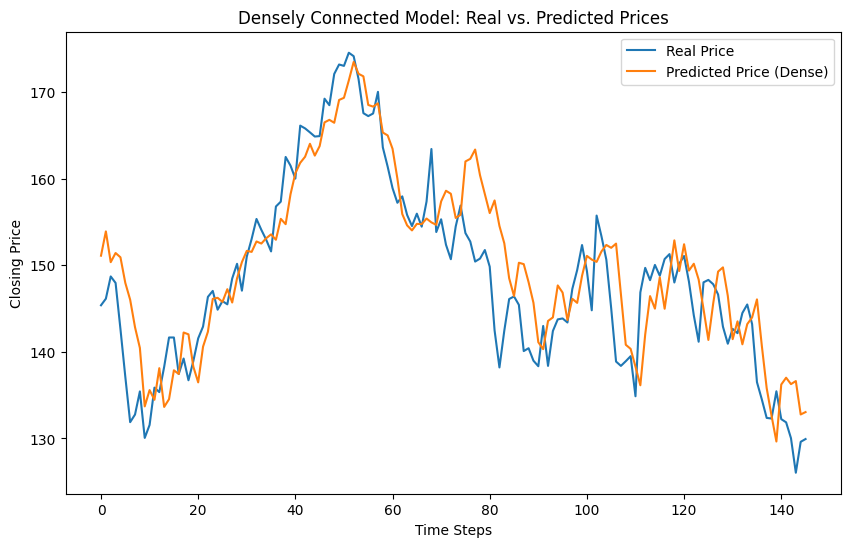

In [38]:
# Gráfico das previsões do modelo Densely Connected vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_dense)), y_pred_dense, label='Predicted Price (Dense)')
plt.title('Densely Connected Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [39]:
# Modelo LSTM
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(50, activation='relu')(inputs)
outputs = layers.Dense(1)(x)
model_lstm = keras.Model(inputs, outputs)

model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento do modelo LSTM
history_lstm = model_lstm.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo LSTM usando MAPE
y_pred_lstm = model_lstm.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
print(f"MAPE LSTM: {mape_lstm:.2f}")



Epoch 1/50
17/17 [==============================] - 2s 41ms/step - loss: 16506.5137 - val_loss: 25510.5859
Epoch 2/50
17/17 [==============================] - 0s 18ms/step - loss: 16270.4678 - val_loss: 25318.6289
Epoch 3/50
17/17 [==============================] - 0s 12ms/step - loss: 15617.4453 - val_loss: 21820.9141
Epoch 4/50
17/17 [==============================] - 0s 13ms/step - loss: 15432.1680 - val_loss: 14112.5645
Epoch 5/50
17/17 [==============================] - 0s 15ms/step - loss: 14429.6484 - val_loss: 16477.7949
Epoch 6/50
17/17 [==============================] - 0s 13ms/step - loss: 13269.4580 - val_loss: 12284.4746
Epoch 7/50
17/17 [==============================] - 0s 11ms/step - loss: 12502.8887 - val_loss: 4286.7827
Epoch 8/50
17/17 [==============================] - 0s 12ms/step - loss: 6260.3228 - val_loss: 1185.2291
Epoch 9/50
17/17 [==============================] - 0s 13ms/step - loss: 755.6606 - val_loss: 1089.0668
Epoch 10/50
17/17 [========================

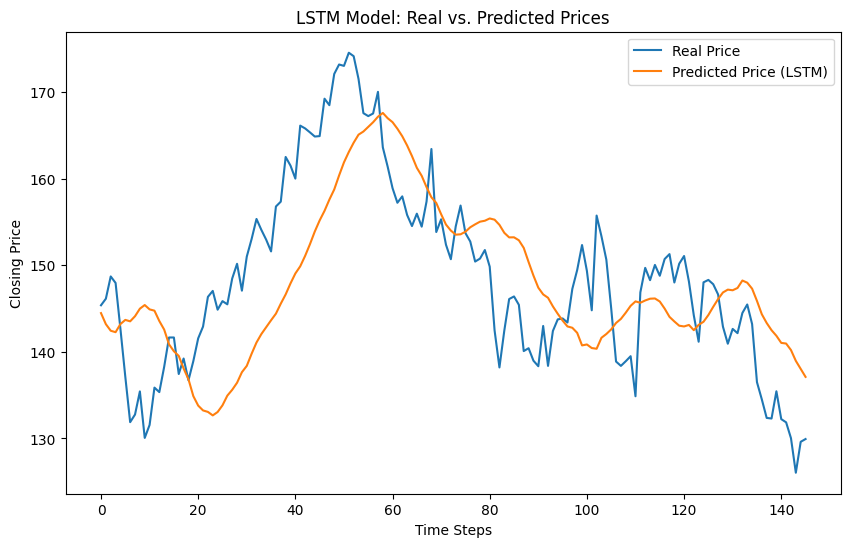

In [40]:
# Gráfico das previsões do modelo LSTM vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted Price (LSTM)')
plt.title('LSTM Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [41]:
# Modelo LSTM com Regularização de Dropout
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2)(inputs)
outputs = layers.Dense(1)(x)
model_lstm_dropout = keras.Model(inputs, outputs)

model_lstm_dropout.compile(optimizer='adam', loss='mse')

# Treinamento do modelo LSTM com Regularização de Dropout
history_lstm_dropout = model_lstm_dropout.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo LSTM com Regularização de Dropout usando MAPE
y_pred_lstm_dropout = model_lstm_dropout.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_lstm_dropout = mean_absolute_percentage_error(y_test, y_pred_lstm_dropout)
print(f"MAPE LSTM with Dropout: {mape_lstm_dropout:.2f}")

Epoch 1/50
17/17 [==============================] - 4s 73ms/step - loss: 16467.5352 - val_loss: 24829.8066
Epoch 2/50
17/17 [==============================] - 1s 45ms/step - loss: 15887.0244 - val_loss: 23704.5820
Epoch 3/50
17/17 [==============================] - 1s 34ms/step - loss: 14828.5898 - val_loss: 22830.4238
Epoch 4/50
17/17 [==============================] - 0s 27ms/step - loss: 14113.8271 - val_loss: 22076.9375
Epoch 5/50
17/17 [==============================] - 0s 25ms/step - loss: 13623.7070 - val_loss: 21572.3555
Epoch 6/50
17/17 [==============================] - 0s 26ms/step - loss: 13290.9365 - val_loss: 21202.3574
Epoch 7/50
17/17 [==============================] - 0s 26ms/step - loss: 13027.9707 - val_loss: 20882.0781
Epoch 8/50
17/17 [==============================] - 0s 27ms/step - loss: 12793.3564 - val_loss: 20587.4414
Epoch 9/50
17/17 [==============================] - 0s 25ms/step - loss: 12574.3320 - val_loss: 20305.6641
Epoch 10/50
17/17 [==================

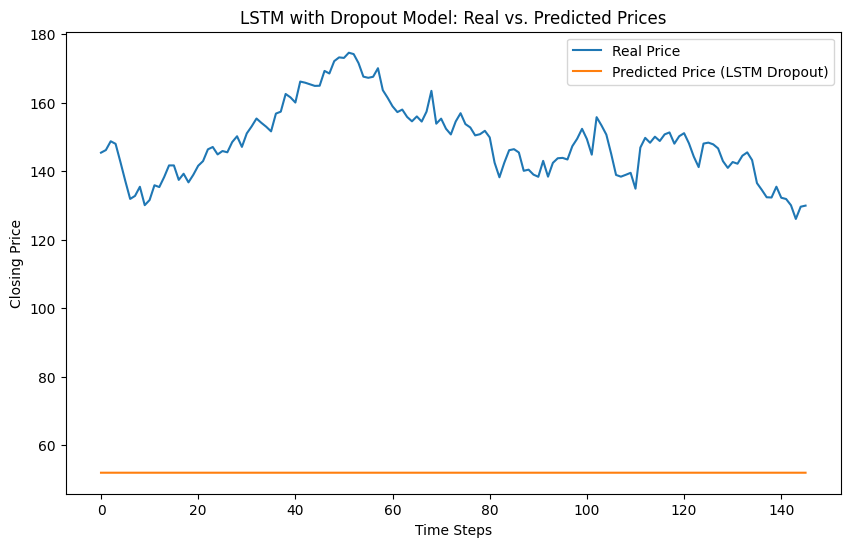

In [42]:
# Gráfico das previsões do modelo LSTM com Regularização de Dropout vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_lstm_dropout)), y_pred_lstm_dropout, label='Predicted Price (LSTM Dropout)')
plt.title('LSTM with Dropout Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [43]:
# Modelo Bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Bidirectional(layers.LSTM(50, activation='relu'))(inputs)
outputs = layers.Dense(1)(x)
model_bidirectional_lstm = keras.Model(inputs, outputs)

model_bidirectional_lstm.compile(optimizer='adam', loss='mse')

# Treinamento do modelo Bidirectional LSTM
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo Bidirectional LSTM usando MAPE
y_pred_bidirectional_lstm = model_bidirectional_lstm.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_bidirectional_lstm = mean_absolute_percentage_error(y_test, y_pred_bidirectional_lstm)
print(f"MAPE Bidirectional LSTM: {mape_bidirectional_lstm:.2f}")

Epoch 1/50
17/17 [==============================] - 3s 38ms/step - loss: 16495.5410 - val_loss: 25467.1719
Epoch 2/50
17/17 [==============================] - 0s 18ms/step - loss: 15533.9238 - val_loss: 12710.9570
Epoch 3/50
17/17 [==============================] - 0s 19ms/step - loss: 14181.3828 - val_loss: 21285.7715
Epoch 4/50
17/17 [==============================] - 0s 18ms/step - loss: 14154.6133 - val_loss: 14919.3262
Epoch 5/50
17/17 [==============================] - 0s 20ms/step - loss: 10696.9121 - val_loss: 4366.2939
Epoch 6/50
17/17 [==============================] - 0s 18ms/step - loss: 2540.1340 - val_loss: 1703.0942
Epoch 7/50
17/17 [==============================] - 0s 17ms/step - loss: 644.0997 - val_loss: 396.9962
Epoch 8/50
17/17 [==============================] - 0s 19ms/step - loss: 179.7537 - val_loss: 358.3694
Epoch 9/50
17/17 [==============================] - 0s 18ms/step - loss: 104.2328 - val_loss: 221.1375
Epoch 10/50
17/17 [==============================] -

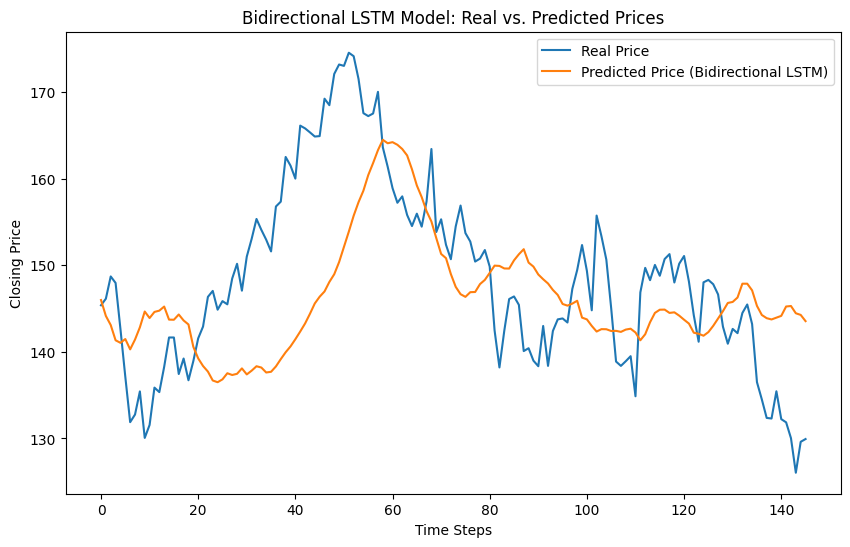

In [44]:
# Gráfico das previsões do modelo Bidirectional LSTM vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_bidirectional_lstm)), y_pred_bidirectional_lstm, label='Predicted Price (Bidirectional LSTM)')
plt.title('Bidirectional LSTM Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

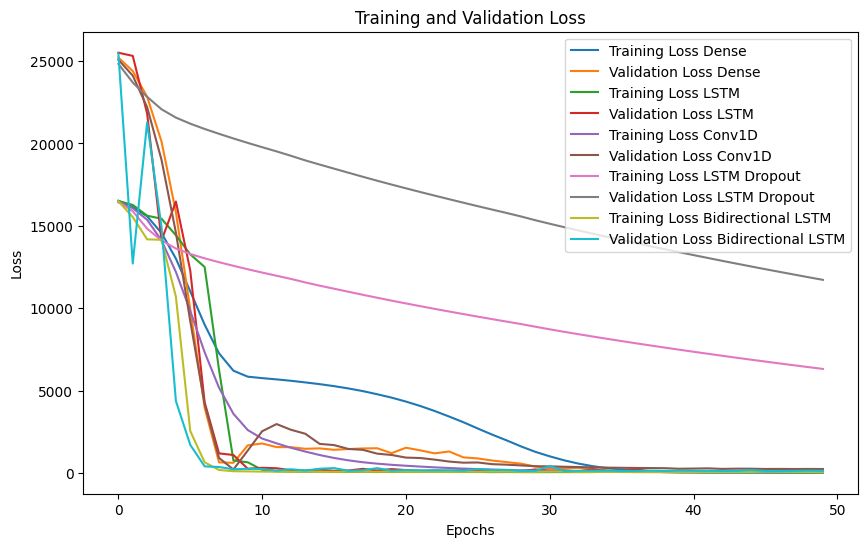

In [45]:
# Visualização da perda durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(history_dense.history['loss'], label='Training Loss Dense')
plt.plot(history_dense.history['val_loss'], label='Validation Loss Dense')
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
plt.plot(history_conv1d.history['loss'], label='Training Loss Conv1D')
plt.plot(history_conv1d.history['val_loss'], label='Validation Loss Conv1D')
plt.plot(history_lstm_dropout.history['loss'], label='Training Loss LSTM Dropout')
plt.plot(history_lstm_dropout.history['val_loss'], label='Validation Loss LSTM Dropout')
plt.plot(history_bidirectional_lstm.history['loss'], label='Training Loss Bidirectional LSTM')
plt.plot(history_bidirectional_lstm.history['val_loss'], label='Validation Loss Bidirectional LSTM')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()